# Starbucks Capstone Challenge: Customer Segmentation

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 


In this notebook we will attempt to divide our customers in segments and evaluate our decisions.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Import Packages

In [1]:
#import holy grail of data science
import pandas as pd
import numpy as np

#helper imports
from cleaner_help import transcript_cleaner

#more imports
import math
import json
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import Imputer , MinMaxScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

#matplot magic
%matplotlib inline


# Load Data

In [2]:
user_df = pd.read_csv("data/user_df.csv")
user_df_median = pd.read_csv("data/user_df_median.csv")

In [3]:
user_df.head()

,Unnamed: 0,person,offer received,offer viewed,offer completed,transaction,reward_infl,amount_infl,email,mobile,...,avg_difficulty,time_to_open,time_to_complete,total_amount,amount_pct,age,gender,income,seen_ratio,completed_ratio
0,0,0,5,5,2,6,5.0,10.52,5,4,...,12.0,0.083929,0.285714,20.40,0.515686,NaN,2,NaN,1.0,0.40
1,1,1,2,0,1,0,5.0,0.00,2,2,...,2.0,1.000000,1.000000,77.01,0.000000,55.0,0,112000.0,0.0,0.50
2,2,2,2,2,0,0,0.0,0.00,2,2,...,2.0,0.000000,1.000000,14.30,0.000000,NaN,2,NaN,1.0,0.00
3,3,3,4,4,3,3,20.0,69.28,4,4,...,5.0,0.234127,0.785714,159.27,0.434985,75.0,0,100000.0,1.0,0.75
4,4,4,5,3,0,1,0.0,1.09,5,2,...,7.0,0.012500,1.000000,4.65,0.234409,NaN,2,NaN,0.6,0.00


# Indentifying Customer Segments

## Reduce Dimensionality 

In [4]:
# Apply feature scaling 
scaler=MinMaxScaler()
#fit scaler
scaler.fit(user_df_median)
#transformed scaled data
user_scaled=scaler.transform(user_df_median)

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [5]:
# Apply PCA to the data
pca_pre= PCA()
pca_pre.fit(user_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [6]:
# Investigate the variance accounted for by each principal component.
pca_pre.explained_variance_ratio_[:10]

array([0.25529689, 0.17180112, 0.12059119, 0.09173236, 0.07484372,
       0.05691177, 0.04650707, 0.04049118, 0.03350932, 0.02797822])

In [7]:
#store cumulative sume of explained variance ratio
cumsum=np.cumsum(pca_pre.explained_variance_ratio_)

In [8]:
#find how many components account for 95% of the variance
pca_95= np.argmax(cumsum>0.95)
print(pca_95)

11


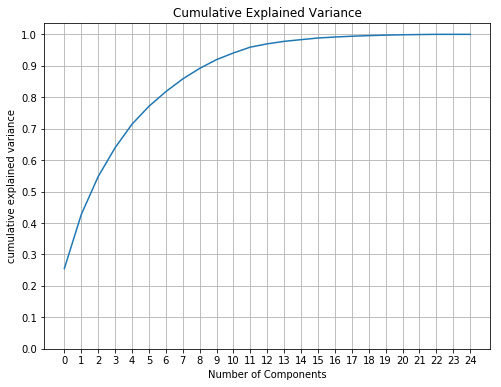

In [9]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca_pre.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative Explained Variance')
plt.xticks(np.arange(0,len(pca_pre.explained_variance_ratio_), 1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(b=True)
plt.savefig('plots/pca_cumsum_pre.png')
plt.show()

In [10]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca=PCA(n_components=pca_95)
pca.fit(user_scaled)

PCA(copy=True, iterated_power='auto', n_components=11, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [11]:
user_pca=pca.transform(user_scaled)
user_pca.shape

(16921, 11)

## Principal Components

In [12]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#index dimensions
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

#PCA componenets
components= pd.DataFrame(np.round(pca.components_, 4), columns=user_df.keys().tolist())
components.index=dimensions
components=components.T

components.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,Dimension 11
Unnamed: 0,-0.0049,-0.0032,-0.7068,0.0004,0.0134,-0.0111,-0.0002,0.0069,0.0006,-0.0017,0.0007
person,-0.0049,-0.0032,-0.7068,0.0004,0.0134,-0.0111,-0.0002,0.0069,0.0006,-0.0017,0.0007
offer received,0.1665,-0.4704,0.0035,-0.0039,0.2223,0.0127,0.0561,0.0307,-0.0057,0.0104,-0.0010
offer viewed,0.1518,-0.2748,-0.0032,-0.0733,-0.3147,-0.1340,-0.1677,0.1657,-0.2091,0.0950,0.0190
offer completed,0.4234,0.0422,-0.0034,-0.0478,0.0100,0.0942,0.0385,-0.0135,-0.1125,-0.3555,0.0238


In [13]:
def comp_weights(components, comp=0, topk=5, saveloc=None):
    #get sorted weights for dimension
    #note that comp 0 corresponds to dimension 1
    
    dim=components.copy()
    dim=dim.iloc[:,comp]
    
    #dim_sort= np.sort(dim)
    dim_sort=dim.sort_values(ascending=True)
    
    #plot the feature weights as a function of the components
    plt.figure(figsize=(20,10))
    plt.bar(x=dim_sort.index, height=dim_sort, tick_label=dim_sort.index)
    plt.xlabel("Features")
    plt.xticks(rotation=90, fontsize=5)
    plt.ylabel("Weights")
    plt.title("Weights of Dimension {}".format(comp+1))
    plt.savefig("plots/expl_var"+str(comp+1)+'.png')
    if saveloc:
        plt.savefig(saveloc)
    
    plt.show()
    
    print("{} most positive weights for the {} component: \n".format(topk, comp+1))
    print(dim_sort[-5:], '\n')
    print("{} most negative weights for the {} component: \n".format(topk, comp+1))
    print(dim_sort[0:5])

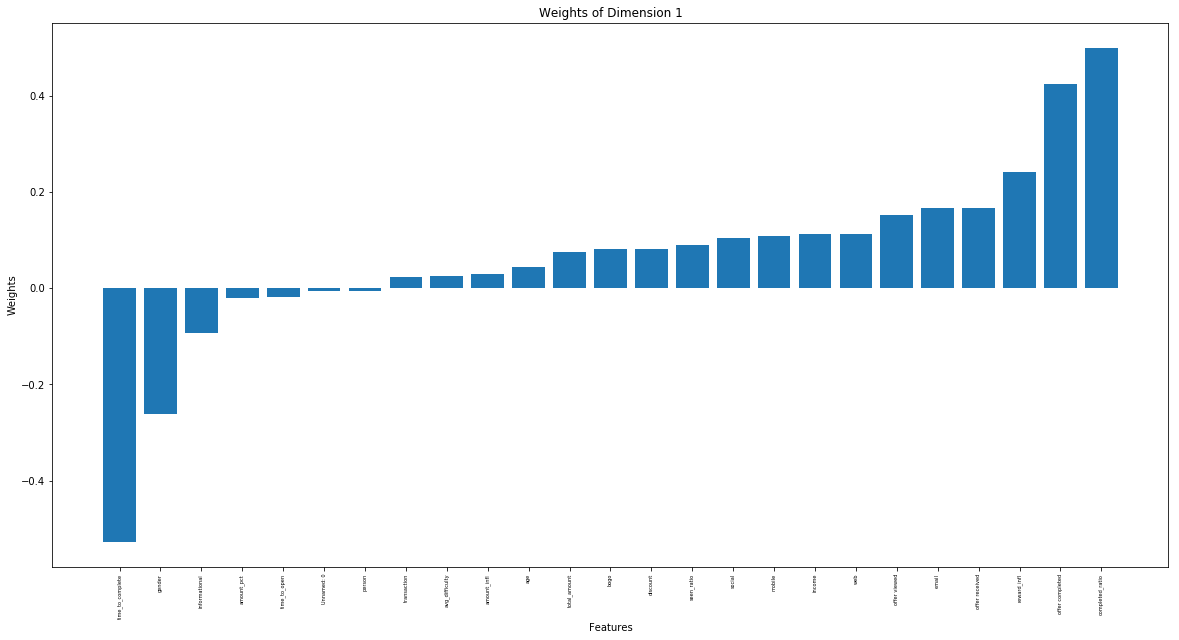

5 most positive weights for the 1 component: 

email              0.1665
offer received     0.1665
reward_infl        0.2416
offer completed    0.4234
completed_ratio    0.4993
Name: Dimension 1, dtype: float64 

5 most negative weights for the 1 component: 

time_to_complete   -0.5271
gender             -0.2608
informational      -0.0921
amount_pct         -0.0207
time_to_open       -0.0189
Name: Dimension 1, dtype: float64


In [14]:
comp_weights(components, 0, saveloc='plots/dim_1.png')

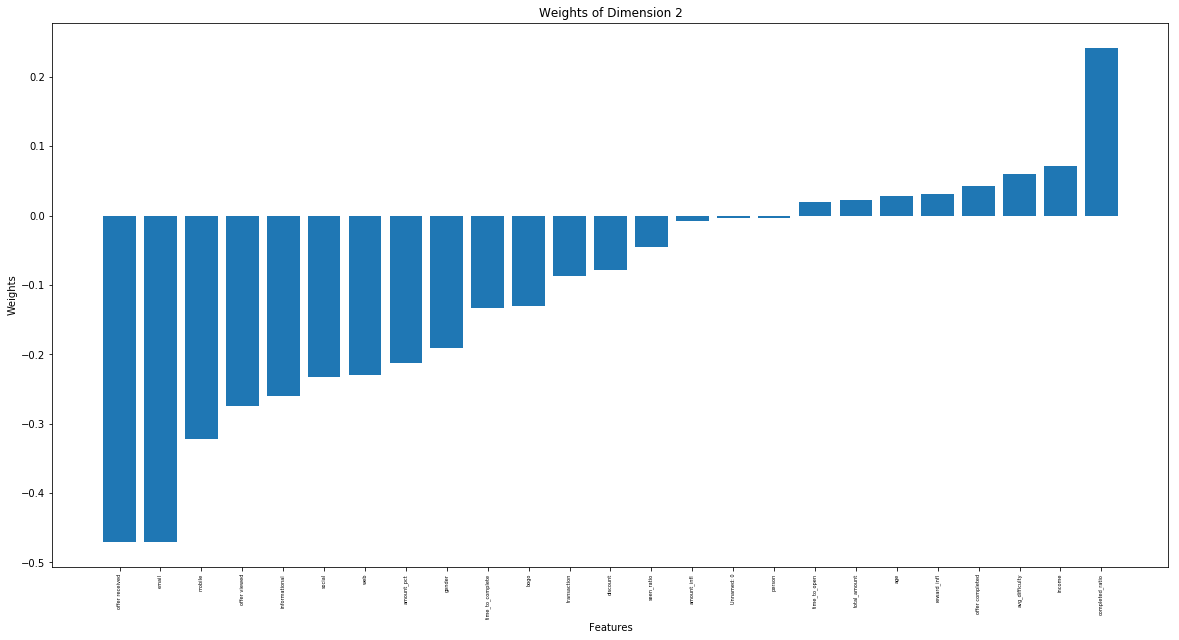

5 most positive weights for the 2 component: 

reward_infl        0.0313
offer completed    0.0422
avg_difficulty     0.0600
income             0.0713
completed_ratio    0.2420
Name: Dimension 2, dtype: float64 

5 most negative weights for the 2 component: 

offer received   -0.4704
email            -0.4704
mobile           -0.3224
offer viewed     -0.2748
informational    -0.2600
Name: Dimension 2, dtype: float64


In [15]:
comp_weights(components, 1,saveloc='plots/dim_2.png')

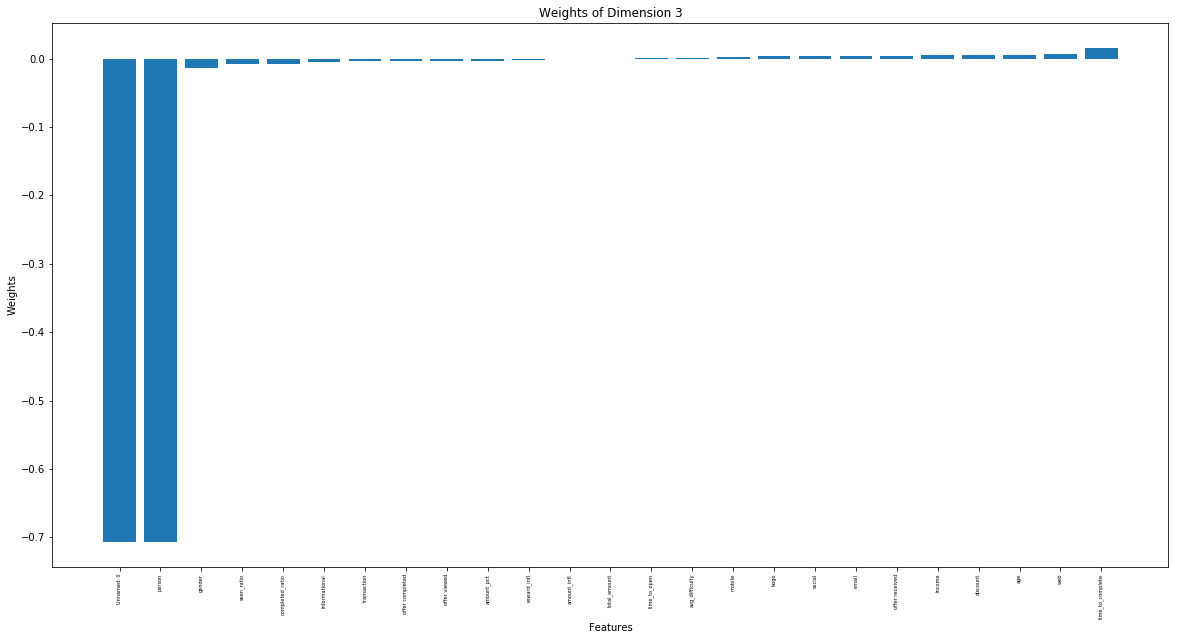

5 most positive weights for the 3 component: 

income              0.0046
discount            0.0050
age                 0.0054
web                 0.0071
time_to_complete    0.0157
Name: Dimension 3, dtype: float64 

5 most negative weights for the 3 component: 

Unnamed: 0        -0.7068
person            -0.7068
gender            -0.0143
seen_ratio        -0.0076
completed_ratio   -0.0073
Name: Dimension 3, dtype: float64


In [16]:
comp_weights(components, 2,saveloc='plots/dim_3.png')

## Clustering

In [17]:
def minik_ssd(df, batch_size=100, K=range(1,30)):
    '''
    Peforms MiniBatchKMeans on dataframe with user specified batch size & range of clusters
    Input:
    - Dataframe
    - Batch size
    - Range of clusters
    Output:
    - Sum of squared distances over range
    
    '''
    #store evolution of ssd
    ssd=[]
    
    #put fancy progress bar on number of clusters
    for k in tqdm(K):
        # intantiate a mini kmeans 
        kmeans_mini=MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
        kmeans_mini.fit(df)
        # compute the average within-cluster distances.
        ssd.append(kmeans_mini.inertia_)
        
    
    return ssd

In [18]:
K=range(1,41)

###get ssd for arbitrary batches
ssd_100=minik_ssd(user_pca, batch_size=100, K=K)
ssd_1000=minik_ssd(user_pca, batch_size=1000, K=K)
ssd_10000=minik_ssd(user_pca, batch_size=10000, K=K)
ssd_20000=minik_ssd(user_pca, batch_size=20000, K=K)
ssd_50000=minik_ssd(user_pca, batch_size=50000, K=K)

100%|██████████| 40/40 [01:09<00:00,  2.48s/it]


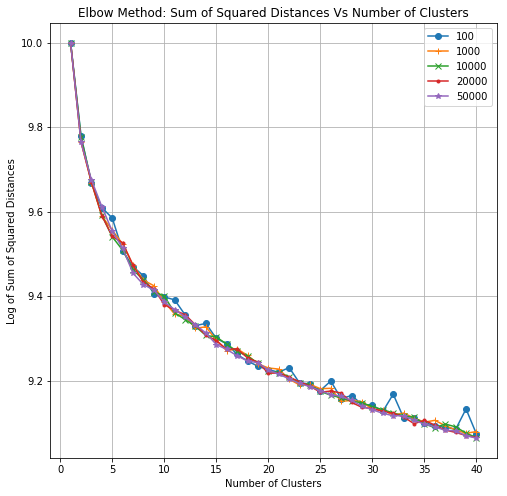

In [19]:
# Investigate the change in within-cluster distance across number of clusters.
# Use matplotlib's plot function to visualize this relationship.


plt.figure(figsize=(8,8))
plt.plot(K, np.log(ssd_100), marker='o') #apply natural log to refuce magnitude
plt.plot(K, np.log(ssd_1000), marker='+')
plt.plot(K, np.log(ssd_10000), marker='x')
plt.plot(K, np.log(ssd_20000), marker='.')
plt.plot(K, np.log(ssd_50000), marker='*')
plt.legend(['100', '1000', '10000', '20000', '50000'], loc='upper right')
plt.xlabel('Number of Clusters')
plt.ylabel('Log of Sum of Squared Distances')
plt.title('Elbow Method: Sum of Squared Distances Vs Number of Clusters')
plt.grid(b=True)
plt.savefig('plots/elbow_minik.png')
plt.show()

In [20]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
best_k=15

kmeans=KMeans(n_clusters=best_k)
kmeans.fit(user_pca)


with open('data/kmeans.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(kmeans, f, pickle.HIGHEST_PROTOCOL)

In [21]:
#get kmeans predictions
kmean_pred = kmeans.fit_predict(user_pca)

#get centroids
centers = kmeans.cluster_centers_

# get silhouette score
silh_score = silhouette_score (user_pca, kmean_pred, metric='euclidean')

print("For {} clusters our silhouette score is {:.3f}".format(best_k, silh_score))

For 15 clusters our silhouette score is 0.100


## Visualize Clusters

In [22]:
#reduce data to 2 components
reduced_data=PCA(n_components=2).fit_transform(user_scaled)
clusters=KMeans(n_clusters=best_k, random_state=42).fit(reduced_data)

In [23]:
#set up meshgrid space
x_min = reduced_data[:, 0].min() -1
x_max = reduced_data[:, 0].max() +1
y_min = reduced_data[:, 1].min() - 1
y_max = reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.

xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

In [24]:
#set up predictions and centroids
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
centroids = clusters.cluster_centers_

In [25]:
def PCA_plot(Z, centroids, saveloc=None):
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(20, 10))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2, alpha=0.1)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    
    if saveloc:
        plt.savefig(saveloc)
    
    plt.show()

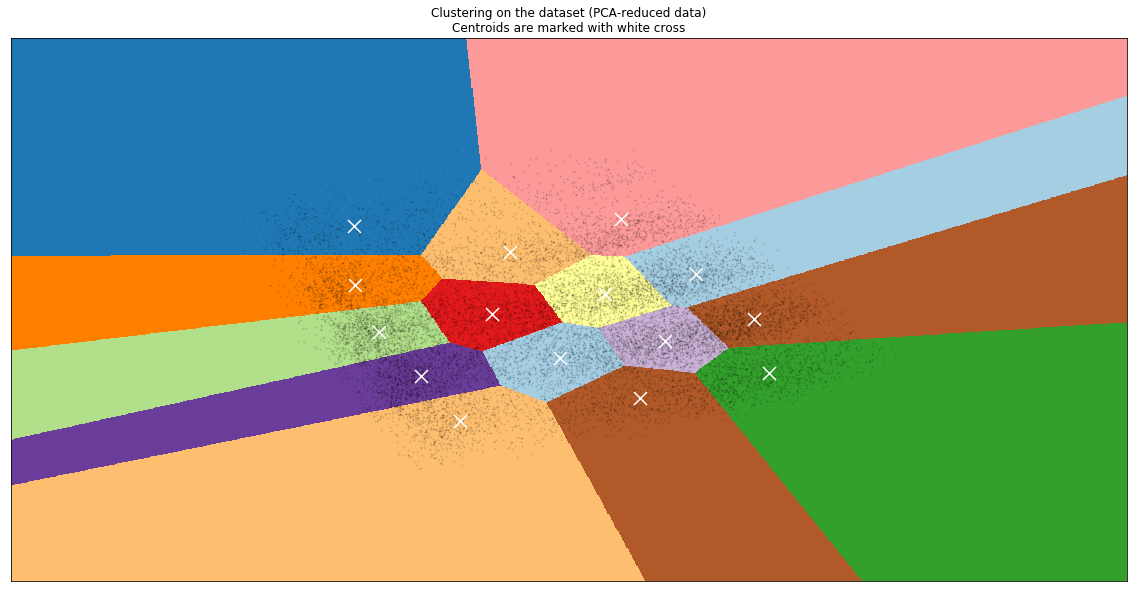

In [26]:
PCA_plot(Z, centroids, 'plots/pca_space.png')

In [27]:
# Compare the proportion of data in each cluster
user_df_kpredict =kmeans.predict(user_pca)

In [28]:
#get frequency of cluster counts for general pop
user_df_freq=np.bincount(user_df_kpredict)/len(user_df_kpredict)

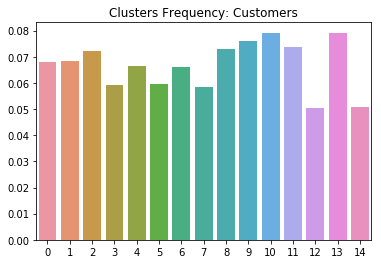

In [29]:
sns.barplot(x=np.arange(0,len(user_df_freq)), y=user_df_freq)
plt.title("Clusters Frequency: Customers")
plt.savefig('plots/FrequencyClusters.png')
plt.show()